# Facial landmark detection with Keras CNN

In this kernel I used Keras to make a simple convolutional neural network (CNN) to detect the eyes, nose and mouth from this database.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['facial_keypoints.csv', 'face_images.npz']


In [ ]:
np.load('../input/face_images.npz')['face_images'].shape

(96, 96, 7049)

In [ ]:
# load the dataset
Pface = np.moveaxis(np.load('../input/face_images.npz')['face_images'],-1,0)
LMs = pd.read_csv('../input/facial_keypoints.csv')

LMpos=LMs.columns.tolist()
print(LMs.isnull().sum())

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
LMs.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [ ]:
LMs_mod = LMs.dropna()
LMs_mod.info()
print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 30 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

In [ ]:
idx = LMs_mod.index.tolist()
len(idx)

2140

In [ ]:
Pface_mod = Pface[idx]
Pface_mod.shape

(2140, 96, 96)

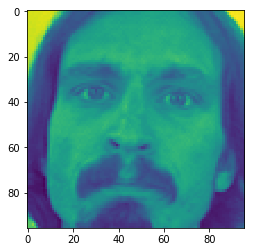

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Pface_mod[0])
plt.show()

I will only select the x and y of the eyes center, nose tip and mouth center, because these values are most avaiable. This gives 7000 images and X and Y are build to fit Keras format. Y is rescaled between 0 and 1.

In [ ]:
# iselect=np.nonzero(LMs.left_eye_center_x.notna() & LMs.right_eye_center_x.notna() &
#          LMs.nose_tip_x.notna() & LMs.mouth_center_bottom_lip_x.notna())[0]

Spic=Pface_mod.shape[1]

X = Pface_mod/255.0
Y = LMs_mod.values/Spic

print(Y.shape)

(2140, 30)


In [ ]:
Y.min(), Y.max(), Spic

(0.03985669850291667, 0.99801024084895829, 96)

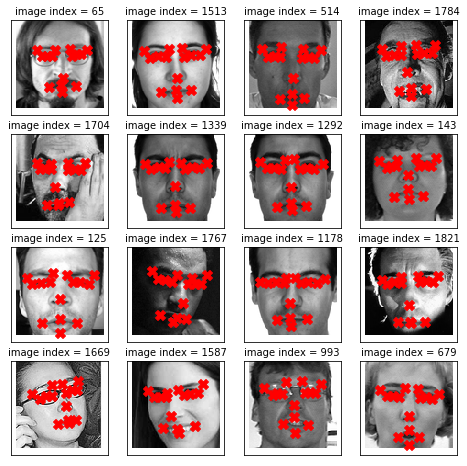

In [ ]:
import matplotlib.pyplot as plt

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Y.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(X[irand[n]], cmap='gray')
        ax[row,col].scatter(Y[irand[n],0::2]*Spic,Y[irand[n],1::2]*Spic,marker='X',c='r',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1


In [ ]:
# Split the dataset
from sklearn.model_selection import train_test_split

random_seed=21
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

The model I used is a very simple CNN just to try if it works. I used the sigmoid activation for the output layer because this produces an output between 0 and 1 and because it is not a classification problem. Softmax is not usefull.

In [ ]:
Xtrain = np.expand_dims(Xtrain, -1)
Xtest = np.expand_dims(Xtest, -1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, SpatialDropout2D
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu', kernel_initializer="he_normal", input_shape=(Spic, Spic, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(30, activation='sigmoid'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

model.fit(Xtrain, Ytrain, batch_size=128, epochs=10, validation_data = (Xtest, Ytest), verbose = 1)

Train on 1712 samples, validate on 428 samples
Epoch 1/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0680 - val_loss: 0.0063
Epoch 2/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0258 - val_loss: 0.0076
Epoch 3/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0178 - val_loss: 0.0036
Epoch 4/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0129 - val_loss: 0.0036
Epoch 5/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0105 - val_loss: 0.0037
Epoch 6/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0094 - val_loss: 0.0037
Epoch 7/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 8/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0082 - val_loss: 0.0035
Epoch 9/10
1712/1712 [==============================] - 10s 6ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 10/10
1712/1712 [===

Text(0.5,0.98,'x: Manual; +: CNN')

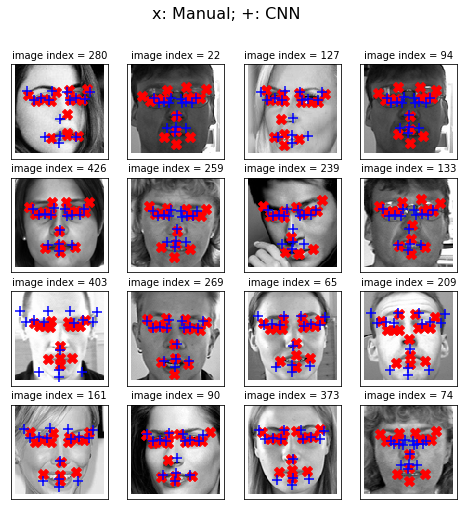

In [ ]:
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)

n = 0
nrows = 4
ncols = 4
irand=np.random.choice(Ytest.shape[0],nrows*ncols)
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=[ncols*2,nrows*2])
for row in range(nrows):
    for col in range(ncols):
        ax[row,col].imshow(Xtest[irand[n]].squeeze(-1), cmap='gray')
        ax[row,col].scatter(Ytest[irand[n],0::2]*Spic,Ytest[irand[n],1::2]*Spic,marker='X',c='r',s=100)
        ax[row,col].scatter(Ytest_pred[irand[n],0::2]*Spic,Ytest_pred[irand[n],1::2]*Spic,marker='+',c='b',s=100)
        ax[row,col].set_xticks(())
        ax[row,col].set_yticks(())
        ax[row,col].set_title('image index = %d' %(irand[n]),fontsize=10)
        n += 1
plt.suptitle('x: Manual; +: CNN', fontsize=16)

Not bad for a first try. Lots of improvements possible.